In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from sklearn.decomposition import PCA
import ccxt
from datetime import datetime

class CryptoRiskAnalysis:
    def __init__(self, assets, start_date, end_date):
        """
        Initializes the analysis class with asset list, start date, and end date for the analysis.
        """
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}
        self.regression_coefficients = {}
        self.trading_signals = {}

    def fetch_data_from_binance(self):
        """
        Fetches historical data from Binance and computes returns, liquidity, and volatility.
        """
        exchange = ccxt.binance()
        for asset in self.assets:
            symbol = f'{asset}/USDT'
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', since=int(self.start_date.timestamp() * 1000), limit=1000)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['return'] = df['close'].pct_change()  # Calculate daily returns
            df['liquidity'] = df['volume'] / df['close']  # Calculate liquidity
            df['volatility'] = df['return'].rolling(window=30).std()  # 30-day volatility
            # Drop rows with NaN values in any of the columns
            df.dropna(subset=['return', 'liquidity', 'volatility'], inplace=True)
            self.data[asset] = df

    def compute_volatility_clustering(self):
        """
        Uses GARCH model to calculate volatility clustering.
        """
        for asset, df in self.data.items():
            if df is not None and 'return' in df.columns:
                returns = df['return'].dropna()
                if len(returns) > 1:
                    garch_model = arch_model(returns, vol='Garch', p=1, q=1)
                    garch_fit = garch_model.fit(disp='off')
                    df['volatility_clustering'] = garch_fit.conditional_volatility
                else:
                    df['volatility_clustering'] = np.nan

    def factor_regression_model(self):
        """
        Runs a regression model to analyze the impact of risk factors on asset returns.
        """
        for asset, df in self.data.items():
            if df is not None:
                df = df.dropna(subset=['return', 'volatility_clustering', 'liquidity'])
                if df.empty:
                    print(f"Not enough data for regression analysis for {asset}.")
                    continue
                X = df[['volatility_clustering', 'liquidity']]
                X = sm.add_constant(X)  # Add constant term
                y = df['return']

                model = sm.OLS(y, X).fit()
                self.regression_coefficients[asset] = model.params

                # Calculate factor contributions
                r_squared = model.rsquared
                factor_contributions = (X * model.params).var() / y.var()
                print(f"Regression Summary for {asset}: {model.summary()}")
                print(f"R-squared: {r_squared}")
                print(f"Factor Contributions: {factor_contributions}")

    def pca_analysis(self):
        """
        Performs Principal Component Analysis (PCA) to identify key risk factors.
        """
        valid_data = [df[['volatility_clustering', 'liquidity']].dropna() for asset, df in self.data.items() if df is not None]
        if not valid_data:
            print("No valid data available for PCA analysis.")
            return
        combined_data = pd.concat(valid_data, axis=0)
        pca = PCA(n_components=2)
        pca.fit(combined_data)
        explained_variance = pca.explained_variance_ratio_

        print(f"Explained Variance by Principal Components: {explained_variance}")

        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=[f'PC{i}' for i in range(1, len(explained_variance) + 1)])
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Explained Variance by Principal Components')
        plt.show()

    def stress_testing(self):
        """
        Performs stress testing by simulating extreme market conditions and assessing asset returns.
        """
        stress_liquidity_drop = -0.5  # Assume a 50% drop in liquidity
        for asset, df in self.data.items():
            if df is not None and not df.empty:
                stressed_returns = df['return'] + (df['liquidity'] * self.regression_coefficients[asset]['liquidity'] * stress_liquidity_drop)
                plt.figure(figsize=(10, 6))
                plt.plot(df.index, df['return'], label='Original Returns')
                plt.plot(df.index, stressed_returns, label='Stressed Returns', linestyle='--')
                plt.title(f'Stress Test for {asset} - Impact of Stressed Liquidity Drop')
                plt.xlabel('Date')
                plt.ylabel('Return')
                plt.legend()
                plt.show()

    def compute_correlations(self):
        """
        Computes the correlation matrix of asset returns.
        """
        valid_data = [df['return'] for asset, df in self.data.items() if df is not None and not df['return'].empty]
        if not valid_data:
            print("No valid data available for correlation computation.")
            return pd.DataFrame()
        combined_data = pd.concat(valid_data, axis=1)
        combined_data.columns = [asset for asset in self.assets if self.data[asset] is not None and not self.data[asset]['return'].empty]
        correlation_matrix = combined_data.corr()
        return correlation_matrix

    def plot_correlations(self):
        """
        Visualizes the correlation matrix of asset returns.
        """
        correlation_matrix = self.compute_correlations()
        if correlation_matrix.empty:
            print("No correlation data available to plot.")
            return
        plt.figure(figsize=(10, 8))
        plt.imshow(correlation_matrix, cmap='viridis', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
        plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
        plt.title('Crypto Asset Correlations')
        plt.show()

    def generate_trading_signals(self, threshold=0.05):
        """
        Generates trading signals based on moving average crossovers or other criteria.
        """
        for asset, df in self.data.items():
            if df is not None:
                short_window = 40
                long_window = 100
                df['short_mavg'] = df['close'].rolling(window=short_window, min_periods=1).mean()
                df['long_mavg'] = df['close'].rolling(window=long_window, min_periods=1).mean()

                df['signal'] = 0
                df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)
                df['trading_signal'] = df['signal'].diff()

                self.trading_signals[asset] = df[['trading_signal']]

                # Plot the trading signals
                plt.figure(figsize=(10, 6))
                plt.plot(df.index, df['close'], label=f'{asset} Price')
                plt.plot(df.index, df['short_mavg'], label=f'{short_window}-day Moving Average')
                plt.plot(df.index, df['long_mavg'], label=f'{long_window}-day Moving Average')
                plt.scatter(df.index[df['trading_signal'] == 1], df['short_mavg'][df['trading_signal'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
                plt.scatter(df.index[df['trading_signal'] == -1], df['short_mavg'][df['trading_signal'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
                plt.title(f"Trading Signals for {asset}")
                plt.legend(loc='best')
                plt.show()

    def run_analysis(self):
        """
        Runs all the analysis methods.
        """
        self.fetch_data_from_binance()  # Fetch data
        self.compute_volatility_clustering()  # Compute volatility clustering
        self.factor_regression_model()  # Run factor regression model
        self.pca_analysis()  # Perform PCA analysis
        self.stress_testing()  # Run stress testing
        self.plot_correlations()  # Plot correlation matrix
        self.generate_trading_signals()  # Generate trading signals


Regression Summary for BTC:                             OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.378
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.253
Time:                        10:55:17   Log-Likelihood:                 1494.9
No. Observations:                 665   AIC:                            -2984.
Df Residuals:                     662   BIC:                            -2970.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
co

C:\Users\cheng\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006559. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\cheng\AppData\Roaming\Python\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\cheng\AppData\Roaming\Python\P

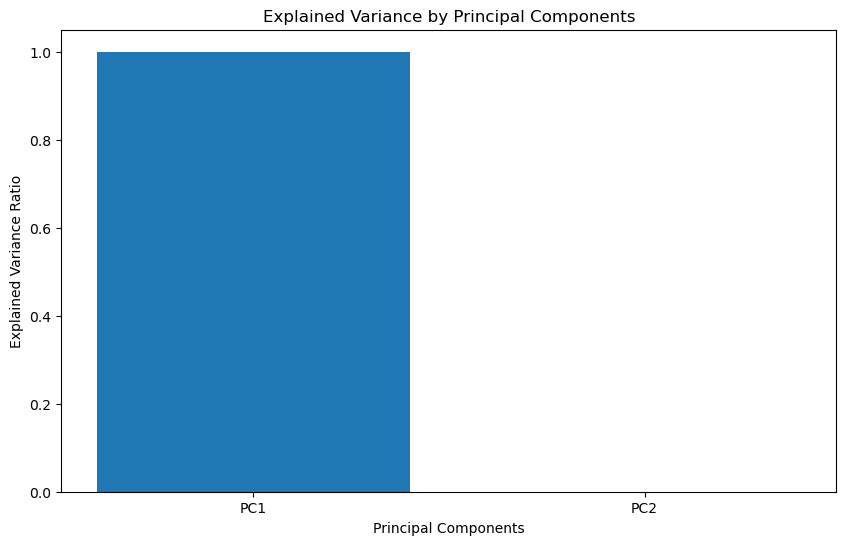

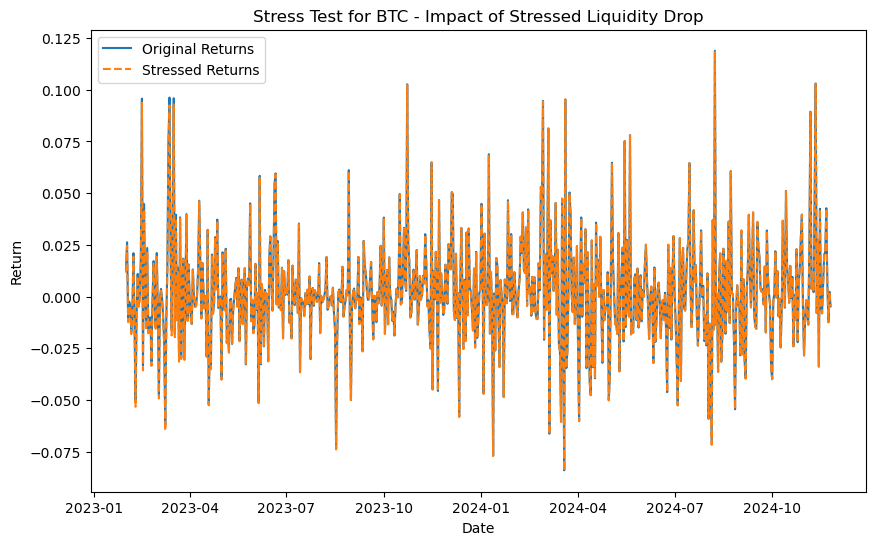

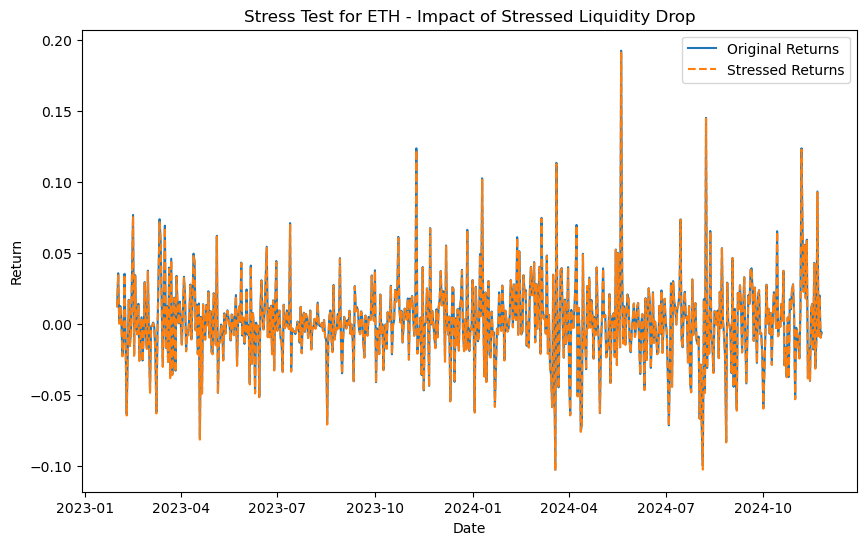

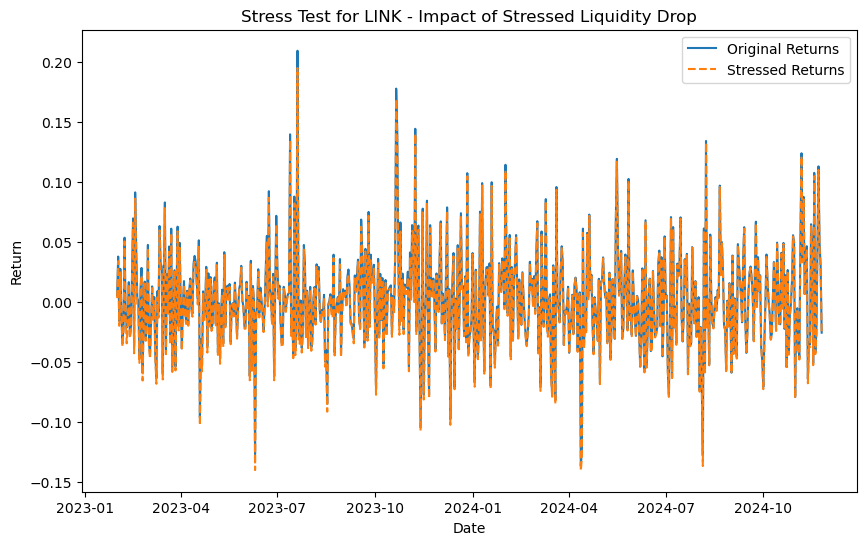

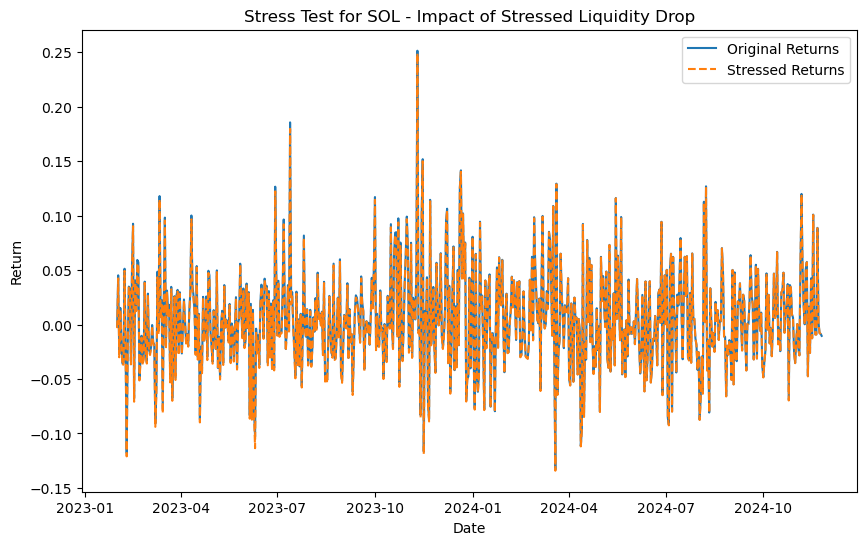

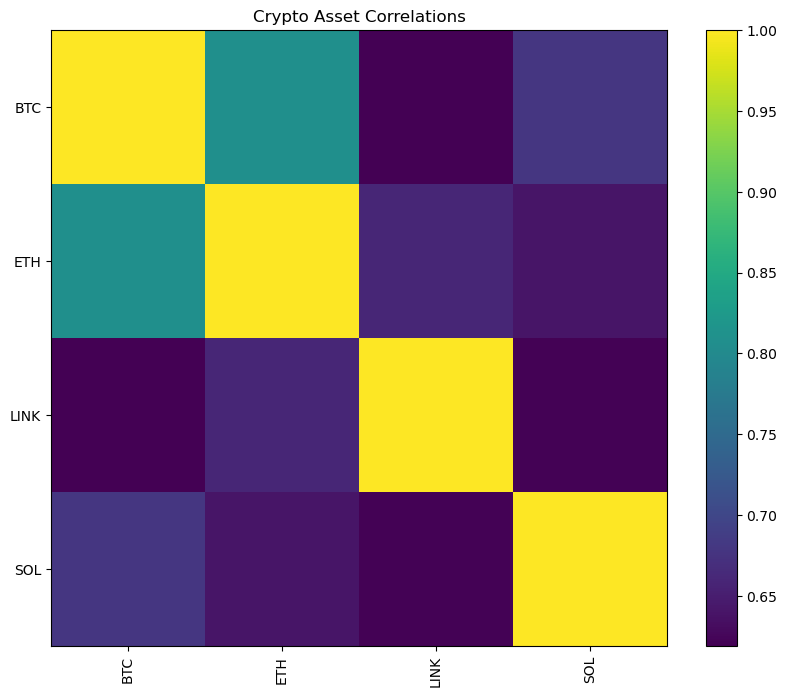

C:\Users\cheng\AppData\Local\Temp\ipykernel_22928\2067985274.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)


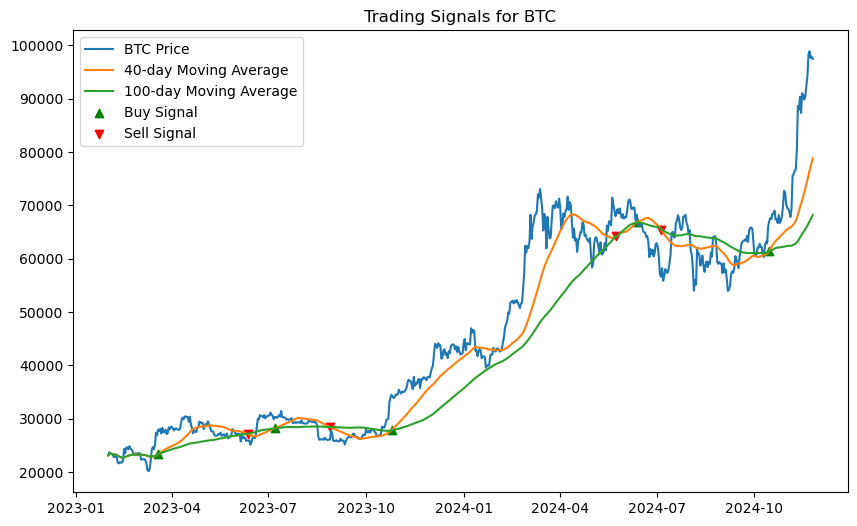

C:\Users\cheng\AppData\Local\Temp\ipykernel_22928\2067985274.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)


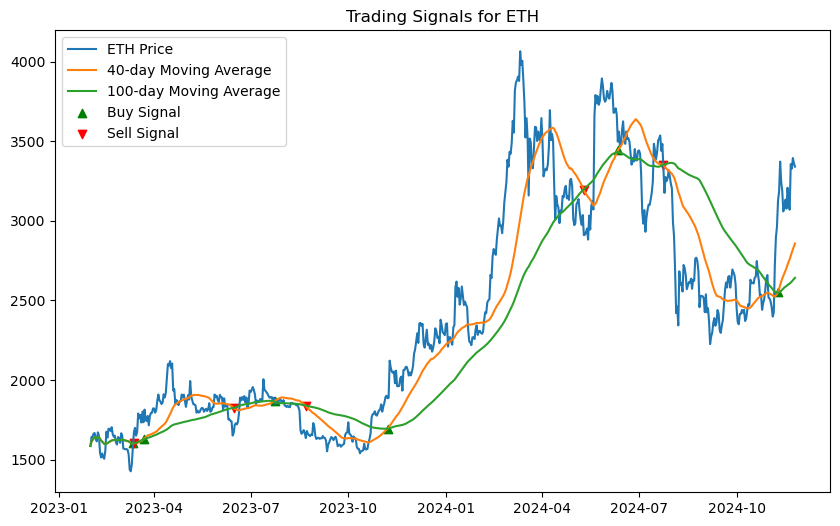

C:\Users\cheng\AppData\Local\Temp\ipykernel_22928\2067985274.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)


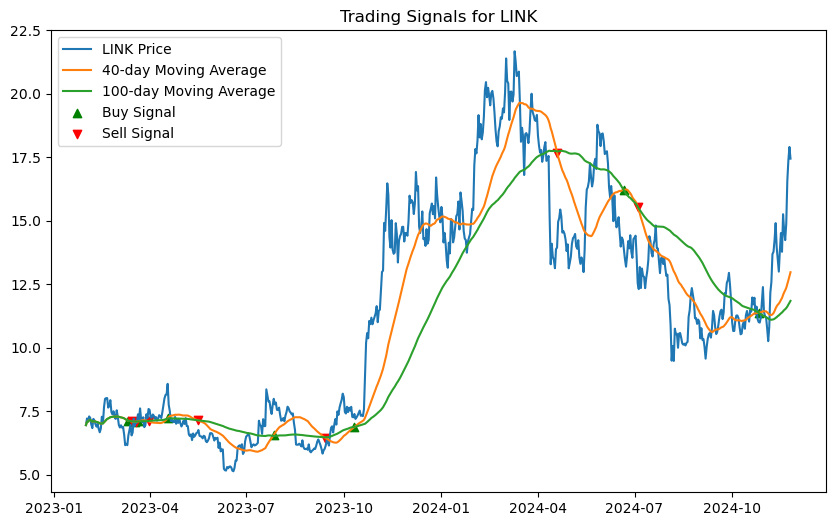

C:\Users\cheng\AppData\Local\Temp\ipykernel_22928\2067985274.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_mavg'][short_window:] > df['long_mavg'][short_window:], 1, 0)


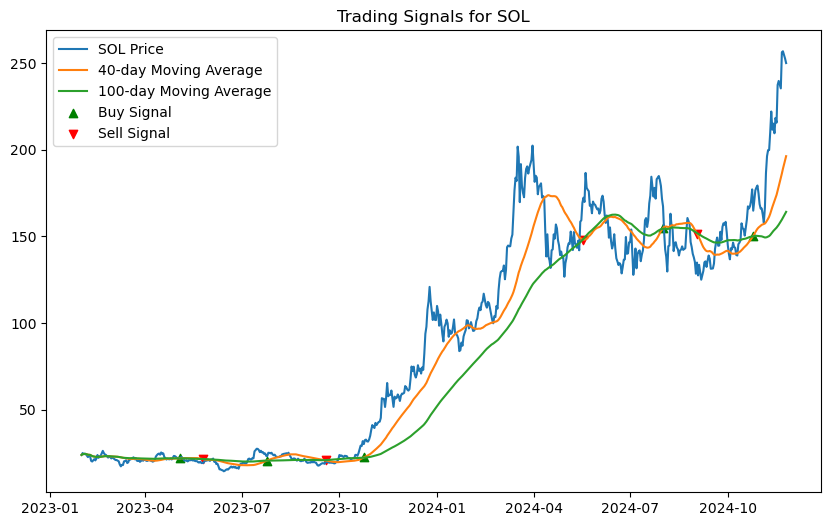

In [46]:
assets = ['BTC', 'ETH','LINK','SOL']
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 1)
analysis = CryptoRiskAnalysis(assets, start_date, end_date)
analysis.run_analysis()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


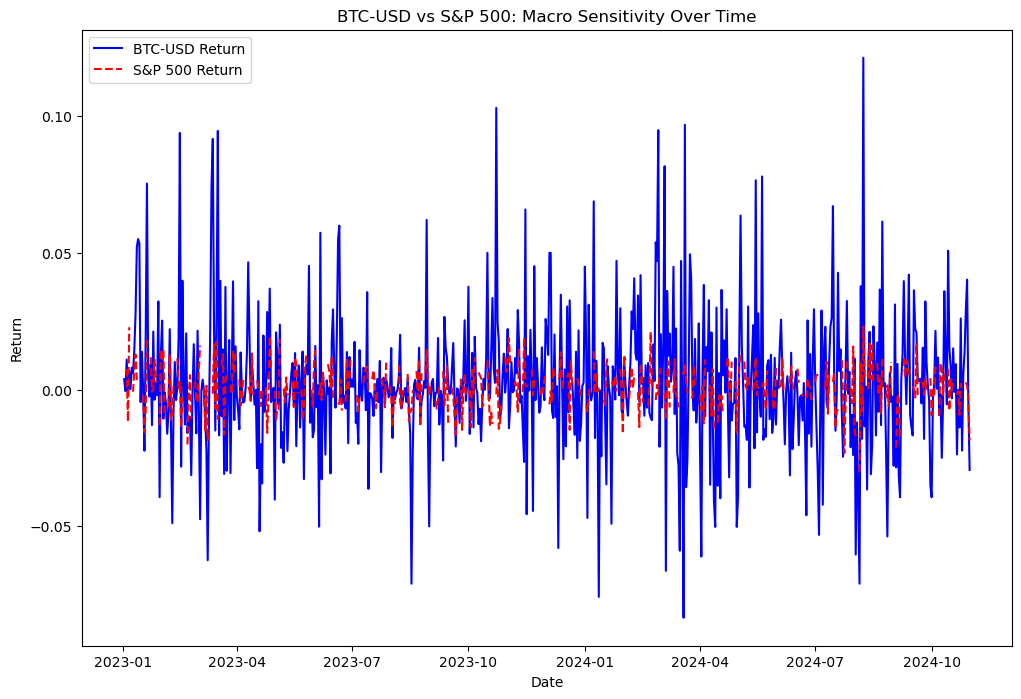

[*********************100%***********************]  1 of 1 completed


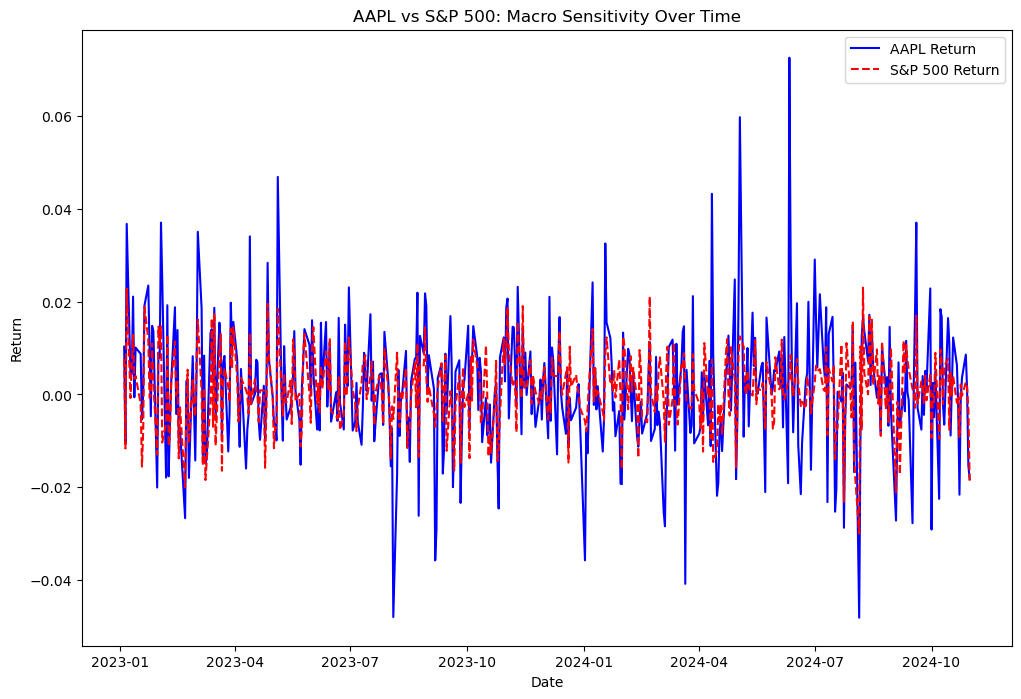

In [47]:
start_date = '2023-01-01'
end_date = '2024-11-01'

# Define assets to analyze (e.g., Bitcoin and Apple)
assets = ['BTC-USD', 'AAPL']  # Bitcoin and Apple against S&P 500

# Instantiate DataAggregator with desired assets and date range
data_aggregator = DataAggregator(assets, start_date, end_date)

# Fetch and store data for each asset
for asset in assets:
    crypto_data = data_aggregator.fetch_crypto_data(asset)
    data_aggregator.data[asset] = crypto_data

# Perform macro sensitivity analysis and plot results
data_aggregator.plot_macro_sensitivity()